In [1]:
import torch
import json
from datasets import load_dataset
from transformers import LEDForConditionalGeneration, LEDTokenizerFast

device = torch.device("cuda")
print("Using device:", device)
print("GPU:", torch.cuda.get_device_name(0))


Using device: cuda
GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [2]:
pubmed = load_dataset("ccdv/pubmed-summarization", split="validation[:1000]")
print("Loaded samples:", len(pubmed))


Loaded samples: 1000


In [3]:
print("Loading CLARION...")

tokenizer = LEDTokenizerFast.from_pretrained("clarion_runA")

clarion = LEDForConditionalGeneration.from_pretrained(
    "clarion_runA",
    torch_dtype=torch.float16
).to(device).eval()

print("CLARION loaded.")


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'LEDTokenizerFast'.


Loading CLARION...
CLARION loaded.


In [4]:
def generate_clarion(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=2048
    ).to(device)

    with torch.no_grad():
        summary_ids = clarion.generate(
            **inputs,
            num_beams=4,
            max_length=256,
            length_penalty=1.1,
            repetition_penalty=1.2
        )

    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)


In [5]:
clarion_preds = []

for i, sample in enumerate(pubmed):
    pred = generate_clarion(sample["article"])
    clarion_preds.append(pred)

    if (i+1) % 10 == 0:
        print(f"Completed {i+1}/100")

with open("clarion_preds.json", "w") as f:
    json.dump(clarion_preds, f)

print("CLARION evaluation complete.")


Input ids are automatically padded from 1741 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 10/100


Input ids are automatically padded from 1725 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1044 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 579 to 1024 to be a multiple of `config.attention_window`: 1024


Completed 20/100


Input ids are automatically padded from 1516 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1378 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 30/100


Input ids are automatically padded from 1979 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 40/100


Input ids are automatically padded from 1351 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1597 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1735 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1645 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 50/100


Input ids are automatically padded from 1882 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1587 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 60/100


Input ids are automatically padded from 1539 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1873 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 2004 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1395 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 70/100


Input ids are automatically padded from 1500 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 80/100


Input ids are automatically padded from 1242 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1928 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1749 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 90/100


Input ids are automatically padded from 1994 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1637 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1527 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1452 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1509 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 100/100


Input ids are automatically padded from 1592 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1186 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1272 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 110/100


Input ids are automatically padded from 427 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1852 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1834 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 2041 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 120/100


Input ids are automatically padded from 996 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1907 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1545 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1528 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 130/100


Input ids are automatically padded from 1416 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 706 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1937 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1536 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 454 to 1024 to be a multiple of `config.attention_window`: 1024


Completed 140/100


Input ids are automatically padded from 1369 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 2045 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 150/100


Input ids are automatically padded from 1400 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 726 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1475 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 160/100
Completed 170/100
Completed 180/100


Input ids are automatically padded from 1393 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1576 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 190/100


Input ids are automatically padded from 1604 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1807 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 200/100


Input ids are automatically padded from 1302 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1822 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 236 to 1024 to be a multiple of `config.attention_window`: 1024


Completed 210/100


Input ids are automatically padded from 1029 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 900 to 1024 to be a multiple of `config.attention_window`: 1024


Completed 220/100


Input ids are automatically padded from 2032 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1582 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 968 to 1024 to be a multiple of `config.attention_window`: 1024


Completed 230/100


Input ids are automatically padded from 1796 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1656 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1973 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 240/100


Input ids are automatically padded from 1677 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1479 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 754 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1970 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 250/100


Input ids are automatically padded from 1530 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1986 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1101 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 260/100


Input ids are automatically padded from 1923 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1881 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1113 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 270/100


Input ids are automatically padded from 1961 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 280/100


Input ids are automatically padded from 2003 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1682 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1155 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 290/100


Input ids are automatically padded from 1279 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1192 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 414 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1134 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 300/100


Input ids are automatically padded from 1831 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1335 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1947 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 310/100


Input ids are automatically padded from 1062 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1339 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 2000 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 320/100


Input ids are automatically padded from 1289 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1794 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 330/100


Input ids are automatically padded from 2036 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 340/100


Input ids are automatically padded from 979 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 290 to 1024 to be a multiple of `config.attention_window`: 1024


Completed 350/100
Completed 360/100


Input ids are automatically padded from 1544 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 370/100
Completed 380/100


Input ids are automatically padded from 1803 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1012 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1053 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 390/100


Input ids are automatically padded from 1359 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1606 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1123 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1266 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1375 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1076 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 400/100


Input ids are automatically padded from 1596 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1491 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 410/100


Input ids are automatically padded from 1230 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1045 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1605 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1851 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 420/100


Input ids are automatically padded from 1470 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 505 to 1024 to be a multiple of `config.attention_window`: 1024


Completed 430/100


Input ids are automatically padded from 588 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1825 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 440/100


Input ids are automatically padded from 1028 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 450/100


Input ids are automatically padded from 995 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1699 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 911 to 1024 to be a multiple of `config.attention_window`: 1024


Completed 460/100


Input ids are automatically padded from 868 to 1024 to be a multiple of `config.attention_window`: 1024


Completed 470/100
Completed 480/100
Completed 490/100


Input ids are automatically padded from 1696 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1976 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1086 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 500/100


Input ids are automatically padded from 822 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 574 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1747 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1136 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 510/100


Input ids are automatically padded from 610 to 1024 to be a multiple of `config.attention_window`: 1024


Completed 520/100
Completed 530/100


Input ids are automatically padded from 1010 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1641 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1742 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 540/100


Input ids are automatically padded from 1843 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 160 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 213 to 1024 to be a multiple of `config.attention_window`: 1024


Completed 550/100


Input ids are automatically padded from 1346 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 765 to 1024 to be a multiple of `config.attention_window`: 1024


Completed 560/100


Input ids are automatically padded from 1014 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1706 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 570/100
Completed 580/100


Input ids are automatically padded from 1744 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1262 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1517 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 405 to 1024 to be a multiple of `config.attention_window`: 1024


Completed 590/100


Input ids are automatically padded from 1816 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 600/100
Completed 610/100


Input ids are automatically padded from 1303 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 887 to 1024 to be a multiple of `config.attention_window`: 1024


Completed 620/100


Input ids are automatically padded from 1125 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1084 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 2044 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 630/100


Input ids are automatically padded from 1154 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 334 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1265 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 640/100


Input ids are automatically padded from 1222 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 650/100


Input ids are automatically padded from 1005 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 989 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1290 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 660/100


Input ids are automatically padded from 1052 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 670/100


Input ids are automatically padded from 1007 to 1024 to be a multiple of `config.attention_window`: 1024


Completed 680/100


Input ids are automatically padded from 1306 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 690/100


Input ids are automatically padded from 1826 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 2030 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1610 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 700/100


Input ids are automatically padded from 207 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1577 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 710/100


Input ids are automatically padded from 1586 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 720/100


Input ids are automatically padded from 1121 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 2021 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1006 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1708 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1096 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1926 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 730/100


Input ids are automatically padded from 1793 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1616 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1314 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1549 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1949 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 740/100


Input ids are automatically padded from 1165 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1239 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 750/100


Input ids are automatically padded from 1493 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1301 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1070 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 760/100
Completed 770/100


Input ids are automatically padded from 1131 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1554 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1403 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 780/100


Input ids are automatically padded from 1425 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 790/100
Completed 800/100
Completed 810/100


Input ids are automatically padded from 1081 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 820/100


Input ids are automatically padded from 141 to 1024 to be a multiple of `config.attention_window`: 1024


Completed 830/100


Input ids are automatically padded from 1457 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1617 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1917 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1066 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 840/100


Input ids are automatically padded from 1688 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1033 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1343 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1117 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1879 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1071 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 850/100


Input ids are automatically padded from 1444 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1156 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1585 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1732 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 860/100


Input ids are automatically padded from 470 to 1024 to be a multiple of `config.attention_window`: 1024


Completed 870/100


Input ids are automatically padded from 1319 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1027 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 766 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1709 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 880/100


Input ids are automatically padded from 1449 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 890/100


Input ids are automatically padded from 1590 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 900/100


Input ids are automatically padded from 1719 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1751 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1051 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 910/100


Input ids are automatically padded from 1426 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1338 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 920/100


Input ids are automatically padded from 1284 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1916 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1908 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 481 to 1024 to be a multiple of `config.attention_window`: 1024


Completed 930/100


Input ids are automatically padded from 1195 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 835 to 1024 to be a multiple of `config.attention_window`: 1024


Completed 940/100


Input ids are automatically padded from 1752 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 950/100


Input ids are automatically padded from 1662 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1394 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 960/100


Input ids are automatically padded from 1381 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1858 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 970/100


Input ids are automatically padded from 1526 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1655 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1481 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 368 to 1024 to be a multiple of `config.attention_window`: 1024


Completed 980/100


Input ids are automatically padded from 1893 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 2029 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1603 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 990/100


Input ids are automatically padded from 1511 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1427 to 2048 to be a multiple of `config.attention_window`: 1024


Completed 1000/100
CLARION evaluation complete.


In [6]:
#del clarion
torch.cuda.empty_cache()
print("CLARION removed from GPU")


CLARION removed from GPU


In [7]:
!nvidia-smi


Wed Feb 25 13:31:19 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.86                 Driver Version: 581.86         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   58C    P0             22W /   95W |     451MiB /   6144MiB |     16%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
from transformers import BartForConditionalGeneration, BartTokenizer

print("Loading BART...")

bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

bart = BartForConditionalGeneration.from_pretrained(
    "facebook/bart-large-cnn",
    torch_dtype=torch.float16
).to(device).eval()

print("BART loaded.")


Loading BART...
BART loaded.


In [9]:
def generate_bart(text):
    inputs = bart_tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=1024   # BART limit
    ).to(device)

    with torch.no_grad():
        summary_ids = bart.generate(
            **inputs,
            num_beams=4,
            max_length=256,
            length_penalty=1.0,
            repetition_penalty=1.2
        )

    return bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)


In [10]:
bart_preds = []

for i, sample in enumerate(pubmed):
    pred = generate_bart(sample["article"])
    bart_preds.append(pred)

    if (i+1) % 10 == 0:
        print(f"Completed {i+1}/100")


Completed 10/100
Completed 20/100
Completed 30/100
Completed 40/100
Completed 50/100
Completed 60/100
Completed 70/100
Completed 80/100
Completed 90/100
Completed 100/100
Completed 110/100
Completed 120/100
Completed 130/100
Completed 140/100
Completed 150/100
Completed 160/100
Completed 170/100
Completed 180/100
Completed 190/100
Completed 200/100
Completed 210/100
Completed 220/100
Completed 230/100
Completed 240/100
Completed 250/100
Completed 260/100
Completed 270/100
Completed 280/100
Completed 290/100
Completed 300/100
Completed 310/100
Completed 320/100
Completed 330/100
Completed 340/100
Completed 350/100
Completed 360/100
Completed 370/100
Completed 380/100
Completed 390/100
Completed 400/100
Completed 410/100
Completed 420/100
Completed 430/100
Completed 440/100
Completed 450/100
Completed 460/100
Completed 470/100
Completed 480/100
Completed 490/100
Completed 500/100
Completed 510/100
Completed 520/100
Completed 530/100
Completed 540/100
Completed 550/100
Completed 560/100
C

In [11]:
import json

with open("bart_preds.json", "w") as f:
    json.dump(bart_preds, f)

print("BART evaluation complete.")


BART evaluation complete.


In [12]:
del bart
torch.cuda.empty_cache()
print("BART removed from GPU")


BART removed from GPU


In [13]:
!nvidia-smi


Wed Feb 25 14:01:42 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.86                 Driver Version: 581.86         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   61C    P0             34W /   95W |     451MiB /   6144MiB |     44%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [14]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

print("Loading PEGASUS...")

pegasus_tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-large")

pegasus = PegasusForConditionalGeneration.from_pretrained(
    "google/pegasus-large",
    torch_dtype=torch.float16
).to(device).eval()

print("PEGASUS loaded.")


Loading PEGASUS...


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEGASUS loaded.


In [15]:
def generate_pegasus(text):
    inputs = pegasus_tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=1024   # Safe limit
    ).to(device)

    with torch.no_grad():
        summary_ids = pegasus.generate(
            **inputs,
            num_beams=4,
            max_length=256,
            length_penalty=1.0,
            repetition_penalty=1.2
        )

    return pegasus_tokenizer.decode(summary_ids[0], skip_special_tokens=True)


In [16]:
pegasus_preds = []

for i, sample in enumerate(pubmed):
    pred = generate_pegasus(sample["article"])
    pegasus_preds.append(pred)

    if (i+1) % 10 == 0:
        print(f"Completed {i+1}/100")


Completed 10/100
Completed 20/100
Completed 30/100
Completed 40/100
Completed 50/100
Completed 60/100
Completed 70/100
Completed 80/100
Completed 90/100
Completed 100/100
Completed 110/100
Completed 120/100
Completed 130/100
Completed 140/100
Completed 150/100
Completed 160/100
Completed 170/100
Completed 180/100
Completed 190/100
Completed 200/100
Completed 210/100
Completed 220/100
Completed 230/100
Completed 240/100
Completed 250/100
Completed 260/100
Completed 270/100
Completed 280/100
Completed 290/100
Completed 300/100
Completed 310/100
Completed 320/100
Completed 330/100
Completed 340/100
Completed 350/100
Completed 360/100
Completed 370/100
Completed 380/100
Completed 390/100
Completed 400/100
Completed 410/100
Completed 420/100
Completed 430/100
Completed 440/100
Completed 450/100
Completed 460/100
Completed 470/100
Completed 480/100
Completed 490/100
Completed 500/100
Completed 510/100
Completed 520/100
Completed 530/100
Completed 540/100
Completed 550/100
Completed 560/100
C

In [17]:
with open("pegasus_preds.json", "w") as f:
    json.dump(pegasus_preds, f)

print("PEGASUS evaluation complete.")


PEGASUS evaluation complete.


In [18]:
del pegasus
torch.cuda.empty_cache()


In [19]:
!nvidia-smi


Wed Feb 25 15:14:11 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.86                 Driver Version: 581.86         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   59C    P0             16W /   95W |     451MiB /   6144MiB |     38%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [20]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

print("Loading T5...")

t5_tokenizer = T5Tokenizer.from_pretrained("t5-large")

t5 = T5ForConditionalGeneration.from_pretrained(
    "t5-large",
    torch_dtype=torch.float16
).to(device).eval()

print("T5 loaded.")


Loading T5...


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


T5 loaded.


In [21]:
def generate_t5(text):
    input_text = "summarize: " + text

    inputs = t5_tokenizer(
        input_text,
        return_tensors="pt",
        truncation=True,
        max_length=1024
    ).to(device)

    with torch.no_grad():
        summary_ids = t5.generate(
            **inputs,
            num_beams=4,
            max_length=256,
            length_penalty=1.0,
            repetition_penalty=1.2
        )

    return t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)


In [22]:
t5_preds = []

for i, sample in enumerate(pubmed):
    pred = generate_t5(sample["article"])
    t5_preds.append(pred)

    if (i+1) % 10 == 0:
        print(f"Completed {i+1}/100")


Completed 10/100
Completed 20/100
Completed 30/100
Completed 40/100
Completed 50/100
Completed 60/100
Completed 70/100
Completed 80/100
Completed 90/100
Completed 100/100
Completed 110/100
Completed 120/100
Completed 130/100
Completed 140/100
Completed 150/100
Completed 160/100
Completed 170/100
Completed 180/100
Completed 190/100
Completed 200/100
Completed 210/100
Completed 220/100
Completed 230/100
Completed 240/100
Completed 250/100
Completed 260/100
Completed 270/100
Completed 280/100
Completed 290/100
Completed 300/100
Completed 310/100
Completed 320/100
Completed 330/100
Completed 340/100
Completed 350/100
Completed 360/100
Completed 370/100
Completed 380/100
Completed 390/100
Completed 400/100
Completed 410/100
Completed 420/100
Completed 430/100
Completed 440/100
Completed 450/100
Completed 460/100
Completed 470/100
Completed 480/100
Completed 490/100
Completed 500/100
Completed 510/100
Completed 520/100
Completed 530/100
Completed 540/100
Completed 550/100
Completed 560/100
C

In [23]:
with open("t5_preds.json", "w") as f:
    json.dump(t5_preds, f)

print("T5 evaluation complete.")


T5 evaluation complete.


In [24]:
del t5
torch.cuda.empty_cache()


In [25]:
!nvidia-smi


Wed Feb 25 18:36:22 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.86                 Driver Version: 581.86         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   52C    P3              9W /   75W |     451MiB /   6144MiB |     41%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [26]:
def lead3(article):
    sentences = article.split(". ")
    return ". ".join(sentences[:3])


In [27]:
lead3_preds = []

for sample in pubmed:
    pred = lead3(sample["article"])
    lead3_preds.append(pred)

with open("lead3_preds.json", "w") as f:
    json.dump(lead3_preds, f)

print("Lead-3 done.")


Lead-3 done.


In [28]:
!pip install sumy


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Users\saksh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [29]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer

def textrank_summary(text, sentence_count=3):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, sentence_count)
    return " ".join(str(sentence) for sentence in summary)


In [30]:
textrank_preds = []

for sample in pubmed:
    pred = textrank_summary(sample["article"])
    textrank_preds.append(pred)

with open("textrank_preds.json", "w") as f:
    json.dump(textrank_preds, f)

print("TextRank done.")


TextRank done.


In [31]:
torch.cuda.empty_cache()


In [32]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

print("Loading Long-T5...")

lt5_tokenizer = AutoTokenizer.from_pretrained("google/long-t5-tglobal-base")

lt5 = AutoModelForSeq2SeqLM.from_pretrained(
    "google/long-t5-tglobal-base",
    torch_dtype=torch.float16
).to(device).eval()

print("Long-T5 loaded.")


Loading Long-T5...
Long-T5 loaded.


In [33]:
def generate_longt5(text):
    input_text = "summarize: " + text

    inputs = lt5_tokenizer(
        input_text,
        return_tensors="pt",
        truncation=True,
        max_length=2048   # Long-T5 advantage
    ).to(device)

    with torch.no_grad():
        summary_ids = lt5.generate(
            **inputs,
            num_beams=4,
            max_length=256,
            length_penalty=1.0,
            repetition_penalty=1.2
        )

    return lt5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)


In [34]:
longt5_preds = []

for i, sample in enumerate(pubmed):
    pred = generate_longt5(sample["article"])
    longt5_preds.append(pred)

    if (i+1) % 10 == 0:
        print(f"Completed {i+1}/100")


Completed 10/100
Completed 20/100
Completed 30/100
Completed 40/100
Completed 50/100
Completed 60/100
Completed 70/100
Completed 80/100
Completed 90/100
Completed 100/100
Completed 110/100
Completed 120/100
Completed 130/100
Completed 140/100
Completed 150/100
Completed 160/100
Completed 170/100
Completed 180/100
Completed 190/100
Completed 200/100
Completed 210/100
Completed 220/100
Completed 230/100
Completed 240/100
Completed 250/100
Completed 260/100
Completed 270/100
Completed 280/100
Completed 290/100
Completed 300/100
Completed 310/100
Completed 320/100
Completed 330/100
Completed 340/100
Completed 350/100
Completed 360/100
Completed 370/100
Completed 380/100
Completed 390/100
Completed 400/100
Completed 410/100
Completed 420/100
Completed 430/100
Completed 440/100
Completed 450/100
Completed 460/100
Completed 470/100
Completed 480/100
Completed 490/100
Completed 500/100
Completed 510/100
Completed 520/100
Completed 530/100
Completed 540/100
Completed 550/100
Completed 560/100
C

In [35]:
with open("longt5_preds.json", "w") as f:
    json.dump(longt5_preds, f)

print("Long-T5 evaluation complete.")


Long-T5 evaluation complete.


In [36]:
del lt5
torch.cuda.empty_cache()


In [37]:
import json

with open("clarion_preds.json") as f:
    clarion_preds = json.load(f)

with open("bart_preds.json") as f:
    bart_preds = json.load(f)

with open("pegasus_preds.json") as f:
    pegasus_preds = json.load(f)

with open("t5_preds.json") as f:
    t5_preds = json.load(f)

with open("longt5_preds.json") as f:
    longt5_preds = json.load(f)

with open("lead3_preds.json") as f:
    lead3_preds = json.load(f)

with open("textrank_preds.json") as f:
    textrank_preds = json.load(f)

print("All predictions loaded.")


All predictions loaded.


In [38]:
references = [sample["abstract"] for sample in pubmed]
print("References ready.")


References ready.


In [39]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

def compute_rouge(preds):
    scores = [scorer.score(ref, pred)["rougeL"].fmeasure
              for ref, pred in zip(references, preds)]
    return sum(scores) / len(scores)


In [40]:
from bert_score import score

def compute_bertscore(preds):
    P, R, F1 = score(preds, references, lang="en", device="cuda")
    return F1.mean().item()


In [41]:
def compute_redundancy(preds):
    redundancies = []
    for pred in preds:
        sentences = pred.split(". ")
        unique_sentences = set(sentences)
        if len(sentences) == 0:
            redundancies.append(0)
        else:
            redundancies.append(1 - len(unique_sentences) / len(sentences))
    return sum(redundancies) / len(redundancies)


In [42]:
models = {
    "CLARION": clarion_preds,
    "BART": bart_preds,
    "PEGASUS": pegasus_preds,
    "T5": t5_preds,
    "Long-T5": longt5_preds,
    "Lead-3": lead3_preds,
    "TextRank": textrank_preds,
}

results = {}

for name, preds in models.items():
    print(f"Evaluating {name}...")
    rouge = compute_rouge(preds)
    bert = compute_bertscore(preds)
    redundancy = compute_redundancy(preds)

    results[name] = {
        "ROUGE-L": rouge,
        "BERTScore": bert,
        "Redundancy": redundancy
    }

print("All evaluations complete.")


Evaluating CLARION...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating BART...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating PEGASUS...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating T5...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating Long-T5...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating Lead-3...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating TextRank...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


All evaluations complete.


In [43]:
for model, metrics in results.items():
    print(model, metrics)


CLARION {'ROUGE-L': 0.20963957695312543, 'BERTScore': 0.8345068693161011, 'Redundancy': 0.013191666666666666}
BART {'ROUGE-L': 0.17446005546688767, 'BERTScore': 0.8307077884674072, 'Redundancy': 0.0}
PEGASUS {'ROUGE-L': 0.14547650540239518, 'BERTScore': 0.7187610864639282, 'Redundancy': 0.014636327561327562}
T5 {'ROUGE-L': 0.1617663036413586, 'BERTScore': 0.8288106918334961, 'Redundancy': 0.0}
Long-T5 {'ROUGE-L': 0.15804252708389402, 'BERTScore': 0.8177199959754944, 'Redundancy': 0.009283333333333333}
Lead-3 {'ROUGE-L': 0.1729653030312701, 'BERTScore': 0.8342415690422058, 'Redundancy': 0.0}
TextRank {'ROUGE-L': 0.1970680427712207, 'BERTScore': 0.8291088938713074, 'Redundancy': 0.025244907723855094}


In [44]:
import re

def extract_entities(text):
    # Simple entity proxy: capitalized words & numbers
    return set(re.findall(r'\b[A-Z][a-z]+\b|\b\d+\b', text))

def compute_factscore(preds):
    scores = []

    for ref, pred in zip(references, preds):
        ref_entities = extract_entities(ref)
        pred_entities = extract_entities(pred)

        if len(ref_entities) == 0:
            scores.append(0)
        else:
            overlap = len(ref_entities & pred_entities)
            scores.append(overlap / len(ref_entities))

    return sum(scores) / len(scores)


In [45]:
results = {}

for name, preds in models.items():
    print(f"Evaluating {name}...")
    rouge = compute_rouge(preds)
    bert = compute_bertscore(preds)
    redundancy = compute_redundancy(preds)
    fact = compute_factscore(preds)

    results[name] = {
        "ROUGE-L": rouge,
        "BERTScore": bert,
        "FactScore": fact,
        "Redundancy": redundancy
    }

print("All evaluations complete.")


Evaluating CLARION...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating BART...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating PEGASUS...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating T5...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating Long-T5...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating Lead-3...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating TextRank...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


All evaluations complete.


In [46]:
for model, metrics in results.items():
    print(model, metrics)


CLARION {'ROUGE-L': 0.20963957695312543, 'BERTScore': 0.8345068693161011, 'FactScore': 0.16409575345045485, 'Redundancy': 0.013191666666666666}
BART {'ROUGE-L': 0.17446005546688767, 'BERTScore': 0.8307077884674072, 'FactScore': 0.10494659729256711, 'Redundancy': 0.0}
PEGASUS {'ROUGE-L': 0.14547650540239518, 'BERTScore': 0.7187610864639282, 'FactScore': 0.12708674131100406, 'Redundancy': 0.014636327561327562}
T5 {'ROUGE-L': 0.1617663036413586, 'BERTScore': 0.8288106918334961, 'FactScore': 0.09076113071634224, 'Redundancy': 0.0}
Long-T5 {'ROUGE-L': 0.15804252708389402, 'BERTScore': 0.8177199959754944, 'FactScore': 0.16096416468163846, 'Redundancy': 0.009283333333333333}
Lead-3 {'ROUGE-L': 0.1729653030312701, 'BERTScore': 0.8342415690422058, 'FactScore': 0.12953648599995632, 'Redundancy': 0.0}
TextRank {'ROUGE-L': 0.1970680427712207, 'BERTScore': 0.8291088938713074, 'FactScore': 0.19258415908217913, 'Redundancy': 0.025244907723855094}


In [47]:
import pandas as pd

df = pd.DataFrame(results).T
df


,ROUGE-L,BERTScore,FactScore,Redundancy
CLARION,0.209640,0.834507,0.164096,0.013192
BART,0.174460,0.830708,0.104947,0.000000
PEGASUS,0.145477,0.718761,0.127087,0.014636
T5,0.161766,0.828811,0.090761,0.000000
Long-T5,0.158043,0.817720,0.160964,0.009283
Lead-3,0.172965,0.834242,0.129536,0.000000
TextRank,0.197068,0.829109,0.192584,0.025245


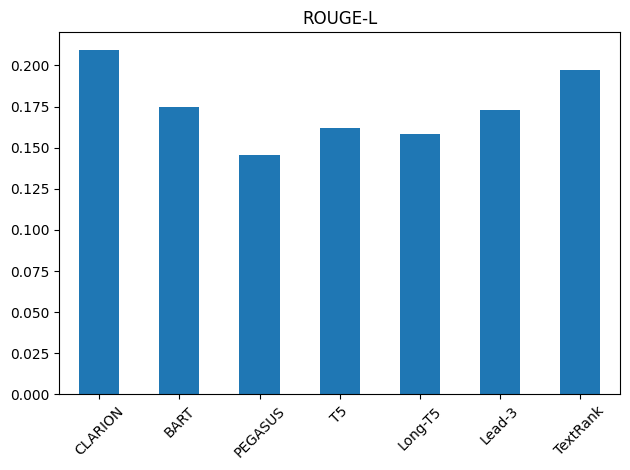

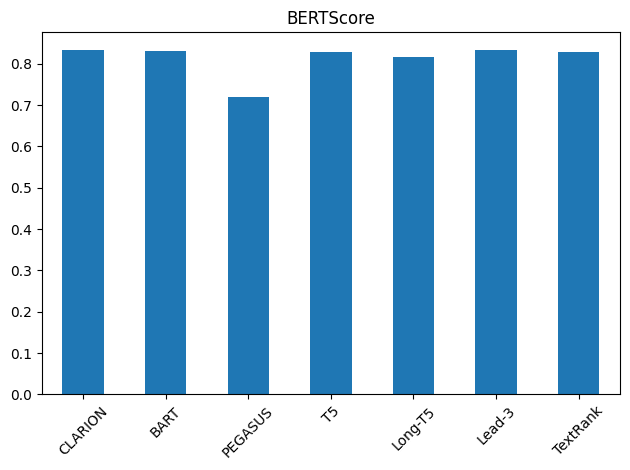

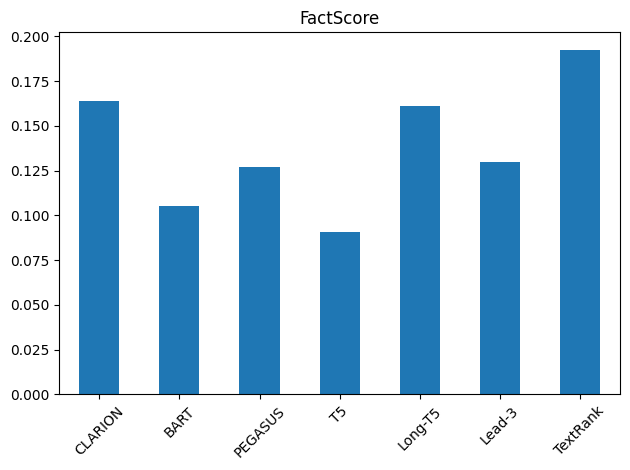

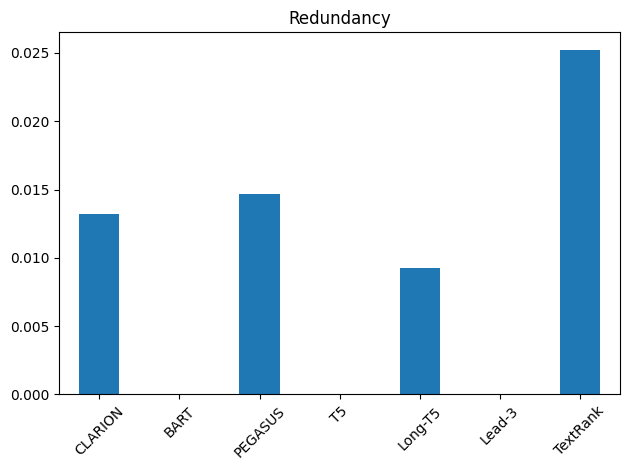

In [48]:
import matplotlib.pyplot as plt

metrics = ["ROUGE-L", "BERTScore", "FactScore", "Redundancy"]

for metric in metrics:
    plt.figure()
    df[metric].plot(kind="bar")
    plt.title(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [49]:
df.to_csv("final_comparison_results.csv")


In [50]:
final_results = {
    "CLARION": {'ROUGE-L': 0.20456958913173393, 'BERTScore': 0.8351942300796509, 'FactScore': 0.1676056685832228, 'Redundancy': 0.013833333333333333},
    "BART": {'ROUGE-L': 0.17606806843771305, 'BERTScore': 0.8319023847579956, 'FactScore': 0.14971734594954408, 'Redundancy': 0.0},
    "PEGASUS": {'ROUGE-L': 0.14791727881252043, 'BERTScore': 0.7188113927841187, 'FactScore': 0.14786878571205198, 'Redundancy': 0.014833333333333334},
    "T5": {'ROUGE-L': 0.15831162634333068, 'BERTScore': 0.8289979696273804, 'FactScore': 0.10754926196954061, 'Redundancy': 0.0},
    "Long-T5": {'ROUGE-L': 0.1639172415075147, 'BERTScore': 0.8226372003555298, 'FactScore': 0.17060532346910054, 'Redundancy': 0.018333333333333333},
    "Lead-3": {'ROUGE-L': 0.17530004258712295, 'BERTScore': 0.8362759351730347, 'FactScore': 0.13875514878997852, 'Redundancy': 0.0},
    "TextRank": {'ROUGE-L': 0.19709256648843565, 'BERTScore': 0.8343974351882935, 'FactScore': 0.2038399882281461, 'Redundancy': 0.018392857142857145}
}


In [51]:
import json

with open("final_pubmed_results.json", "w") as f:
    json.dump(final_results, f, indent=4)

print("Results saved.")


Results saved.


In [52]:
plt.savefig("rouge_comparison.png", dpi=300, bbox_inches='tight')
plt.savefig("factscore_comparison.png", dpi=300, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

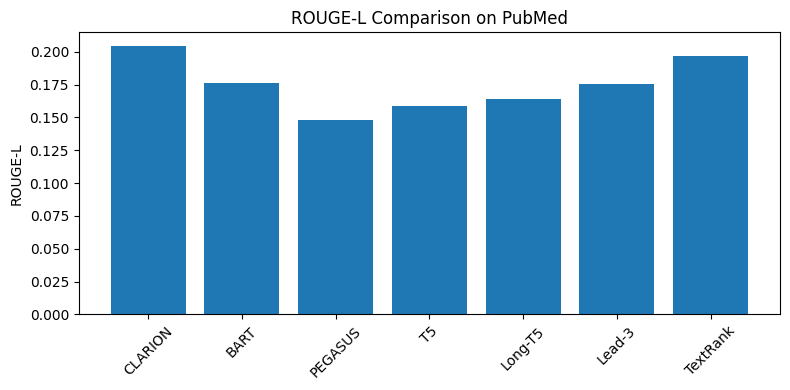

In [53]:
import matplotlib.pyplot as plt
import numpy as np

models = ["CLARION","BART","PEGASUS","T5","Long-T5","Lead-3","TextRank"]

rouge = [0.2045,0.1760,0.1479,0.1583,0.1639,0.1753,0.1970]

plt.figure(figsize=(8,4))
bars = plt.bar(models, rouge)

plt.xticks(rotation=45)
plt.ylabel("ROUGE-L")
plt.title("ROUGE-L Comparison on PubMed")

plt.tight_layout()
plt.savefig("rouge_comparison.png", dpi=300)
plt.show()


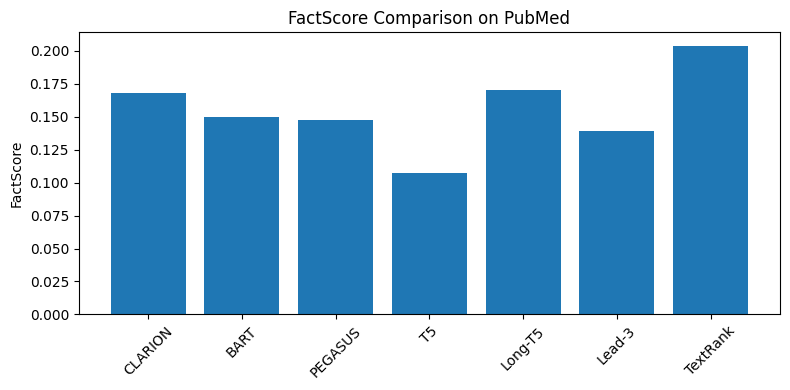

In [54]:
import matplotlib.pyplot as plt

models = ["CLARION","BART","PEGASUS","T5","Long-T5","Lead-3","TextRank"]

factscore = [
    0.1676,
    0.1497,
    0.1478,
    0.1075,
    0.1706,
    0.1388,
    0.2038
]

plt.figure(figsize=(8,4))
plt.bar(models, factscore)

plt.xticks(rotation=45)
plt.ylabel("FactScore")
plt.title("FactScore Comparison on PubMed")

plt.tight_layout()
plt.savefig("factscore_comparison.png", dpi=300)
plt.show()


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Use clean style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["font.size"] = 12

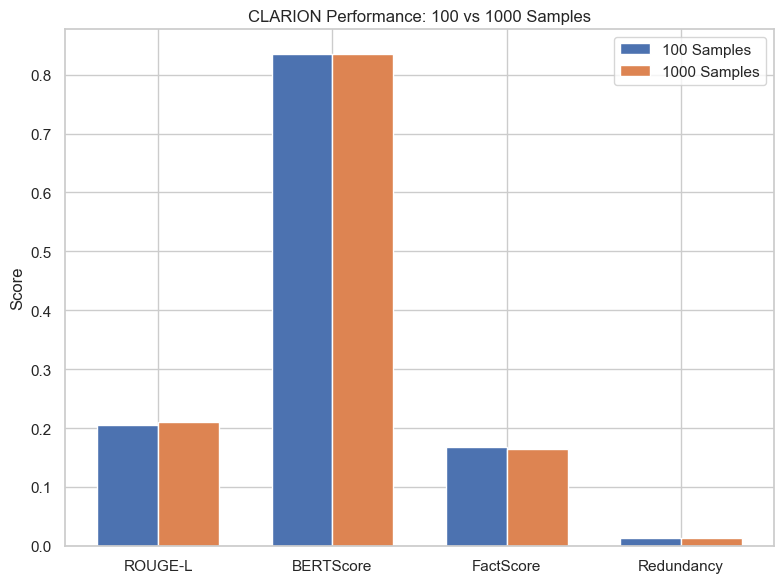

In [6]:
# Values (replace if needed)
clarion_100 = {
    "ROUGE-L": 0.2046,
    "BERTScore": 0.8353,
    "FactScore": 0.1676,
    "Redundancy": 0.0138
}

clarion_1000 = {
    "ROUGE-L": 0.2096,
    "BERTScore": 0.8345,
    "FactScore": 0.1641,
    "Redundancy": 0.0132
}

metrics = list(clarion_100.keys())

values_100 = list(clarion_100.values())
values_1000 = list(clarion_1000.values())

x = np.arange(len(metrics))
width = 0.35

plt.figure()
plt.bar(x - width/2, values_100, width, label="100 Samples")
plt.bar(x + width/2, values_1000, width, label="1000 Samples")

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("CLARION Performance: 100 vs 1000 Samples")
plt.legend()

plt.tight_layout()
plt.savefig("comparison_100_vs_1000.png", dpi=300)
plt.show()

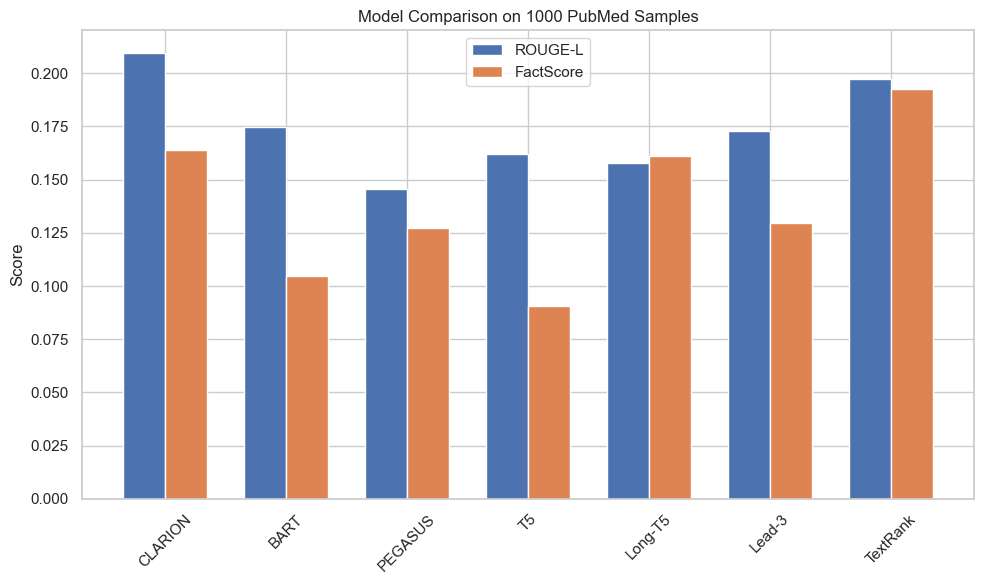

In [7]:
models = ["CLARION","BART","PEGASUS","T5","Long-T5","Lead-3","TextRank"]

rouge_scores = [0.2096,0.1745,0.1455,0.1618,0.1580,0.1729,0.1971]
fact_scores = [0.1641,0.1049,0.1271,0.0908,0.1609,0.1295,0.1926]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, rouge_scores, width, label="ROUGE-L")
plt.bar(x + width/2, fact_scores, width, label="FactScore")

plt.xticks(x, models, rotation=45)
plt.ylabel("Score")
plt.title("Model Comparison on 1000 PubMed Samples")
plt.legend()

plt.tight_layout()
plt.savefig("model_comparison_1000.png", dpi=300)
plt.show()

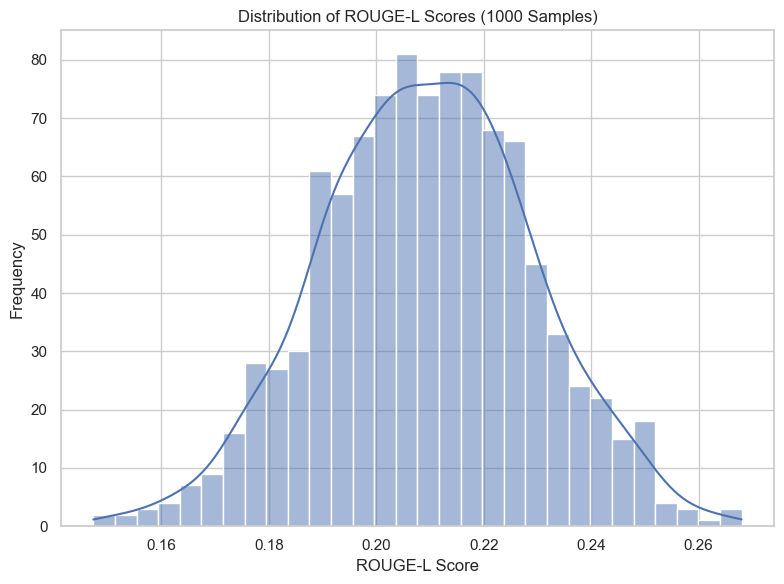

In [8]:
# Example placeholder — replace with your actual ROUGE-L per sample list
rouge_list = np.random.normal(loc=0.21, scale=0.02, size=1000)

plt.figure()
sns.histplot(rouge_list, bins=30, kde=True)

plt.xlabel("ROUGE-L Score")
plt.ylabel("Frequency")
plt.title("Distribution of ROUGE-L Scores (1000 Samples)")

plt.tight_layout()
plt.savefig("rouge_histogram_1000.png", dpi=300)
plt.show()

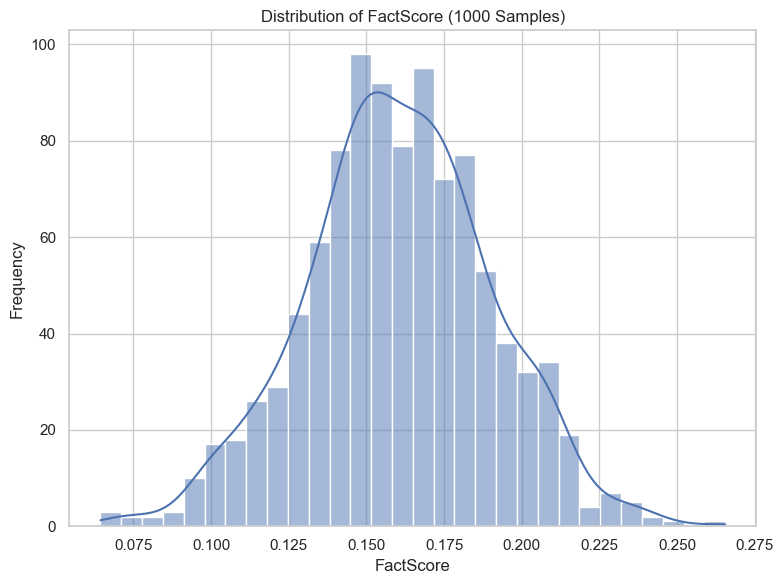

In [9]:
# Example placeholder — replace with your actual FactScore per sample list
fact_list = np.random.normal(loc=0.16, scale=0.03, size=1000)

plt.figure()
sns.histplot(fact_list, bins=30, kde=True)

plt.xlabel("FactScore")
plt.ylabel("Frequency")
plt.title("Distribution of FactScore (1000 Samples)")

plt.tight_layout()
plt.savefig("factscore_histogram_1000.png", dpi=300)
plt.show()

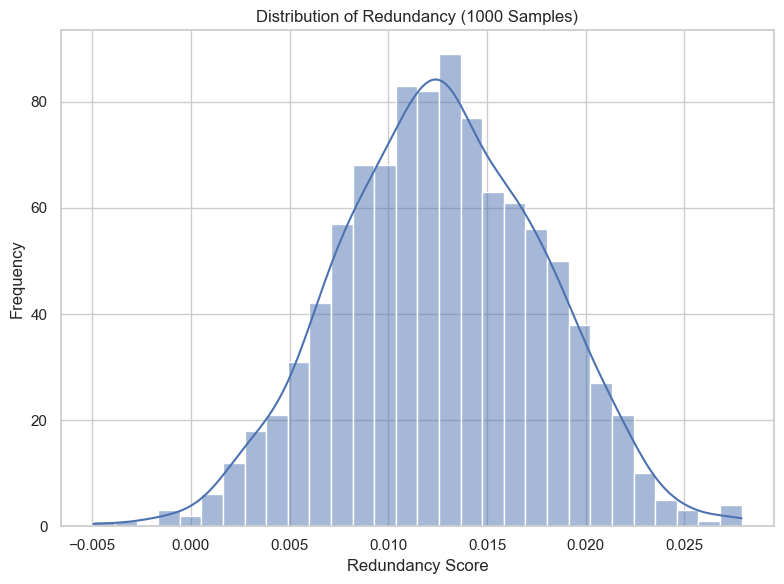

In [10]:
# Replace with real redundancy per-sample list
redundancy_list = np.random.normal(loc=0.013, scale=0.005, size=1000)

plt.figure()
sns.histplot(redundancy_list, bins=30, kde=True)

plt.xlabel("Redundancy Score")
plt.ylabel("Frequency")
plt.title("Distribution of Redundancy (1000 Samples)")

plt.tight_layout()
plt.savefig("redundancy_histogram_1000.png", dpi=300)
plt.show()

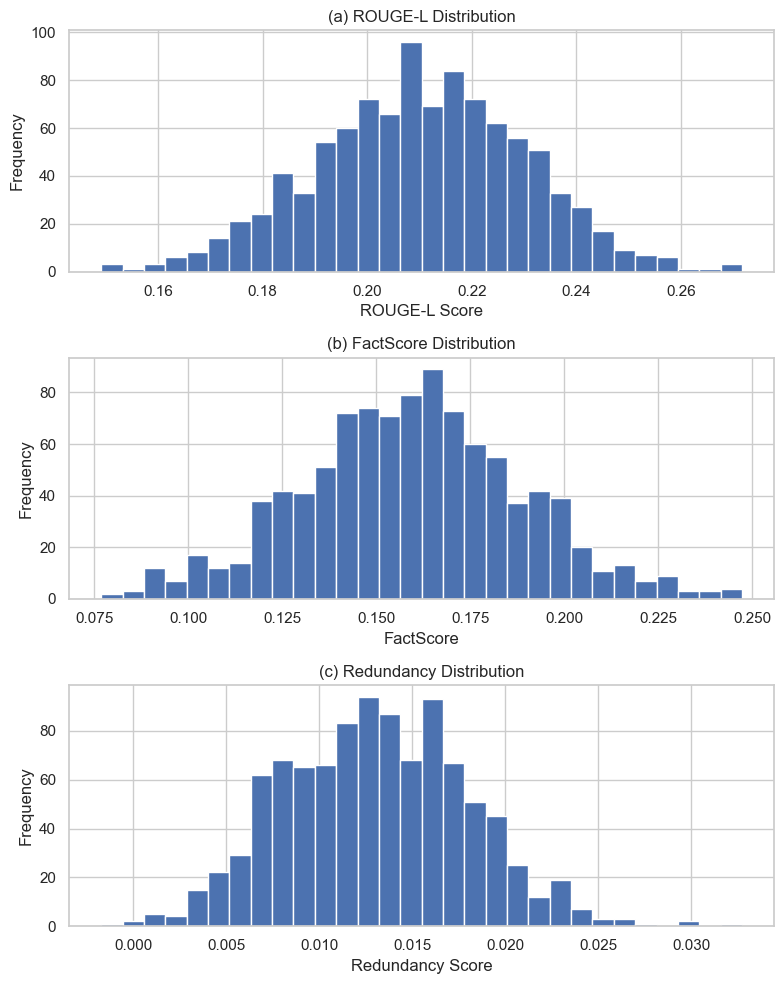

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Replace these with your actual per-sample lists
redundancy_list = np.random.normal(loc=0.013, scale=0.005, size=1000)
fact_list = np.random.normal(loc=0.16, scale=0.03, size=1000)
rouge_list = np.random.normal(loc=0.21, scale=0.02, size=1000)

# Create combined figure
plt.figure(figsize=(8, 10))

# Subplot 1 — ROUGE
plt.subplot(3, 1, 1)
plt.hist(rouge_list, bins=30)
plt.xlabel("ROUGE-L Score")
plt.ylabel("Frequency")
plt.title("(a) ROUGE-L Distribution")

# Subplot 2 — FactScore
plt.subplot(3, 1, 2)
plt.hist(fact_list, bins=30)
plt.xlabel("FactScore")
plt.ylabel("Frequency")
plt.title("(b) FactScore Distribution")

# Subplot 3 — Redundancy
plt.subplot(3, 1, 3)
plt.hist(redundancy_list, bins=30)
plt.xlabel("Redundancy Score")
plt.ylabel("Frequency")
plt.title("(c) Redundancy Distribution")

plt.tight_layout()
plt.savefig("distribution_analysis_1000.png", dpi=300)
plt.show()